
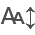

In [1]:
import pandas as pd
from pathlib import Path
import os
from Utils.Utils import check_single_rec_file, get_timestamps_from_rec
from spikeinterface.sorters import read_sorter_folder
from spikeinterface.extractors import read_spikegadgets
from tqdm.notebook import tqdm
import numpy as np
import matplotlib.pyplot as plt
from spikeinterface.extractors import read_phy
import panel as pn
pn.extension('tabulator',design="bootstrap", sizing_mode="fixed",throttled=True)

from itables import init_notebook_mode

init_notebook_mode(all_interactive=True)

# Select session

In [2]:

# folder containing .rec file
path_recording_folder = Path(r"/alzheimer/Roberto/Dariya/12/ephys/20231210_191835.rec/")
#path_recording_folder = Path(r"O:\data\12\ephys\20240126_184212.rec")

path_recording, rec_file_name = check_single_rec_file(path_recording_folder)

Exactly one .rec file found: 20231210_191835.rec


## Load Trials

In [3]:
# if needed convert columns names to snake case with: from utils.Utils import camel_to_snake; trials.columns = [camel_to_snake(column) for column in trials.columns]

trials = pd.read_csv(Path(f"{path_recording_folder}/trials.csv"))
print(trials["stimulus_name"].unique())

['BpodProtocols_DetectionConfidence.git']


In [4]:
trials

trial_n  bpod_start_time  bpod_stop_time  stimulus_block  \
0         0           7.4648         18.4899               0   
1         1          19.4012         30.4263               0   
2         2          31.2975         42.3226               0   
3         3          43.1718         54.1969               0   
4         4          55.0648         66.0899               0   
..      ...              ...             ...             ...   
93       93         945.8506        956.8757               0   
94       94         957.7820        971.1213               0   
95       95         971.9916        983.0167               0   
96       96         983.9097        987.9648               0   
97       97         988.8510        999.8761               0   

                            stimulus_name  after_trial_interval  \
0   BpodProtocols_DetectionConfidence.git                     1   
1   BpodProtocols_DetectionConfidence.git                     1   
2   BpodProtocols_DetectionConfidence.git                     1   
3   BpodProtocols_DetectionConfidence.git                     1   
4   BpodProtocols_DetectionConfidence.git                     1   
..                                    ...                   ...   
93  BpodProtocols_DetectionConfidence.git                     1   
94  BpodProtocols_DetectionConfidence.git                     1   
95  BpodProtocols_DetectionConfidence.git                     1   
96  BpodProtocols_DetectionConfidence.git                     1   
97  BpodProtocols_DetectionConfidence.git                     1   

    before_trial_interval      beta  bias_version  block_bias  ...  \
0                       1 -0.847712             1         0.5  ...   
1                       1 -0.997810             1         0.5  ...   
2                       1 -1.000000             1         0.5  ...   
3                       1  1.000000             1         0.5  ...   
4                       1 -0.986815             1         0.5  ...   
..                    ...       ...           ...         ...  ...   
93                      1  0.201691             1         0.5  ...   
94                      1 -0.920038             1         0.5  ...   
95                      1 -0.189392             1         0.5  ...   
96                      1 -0.378655             1         0.5  ...   
97                      1 -0.057001             1         0.5  ...   

    reward_start_time  d_i_o_start_sample  d_i_o_start_time  \
0                 NaN             1608245         53.608167   
1                 NaN             1966340         65.544667   
2                 NaN             2323233         77.441100   
3                 NaN             2679466         89.315533   
4                 NaN             3036260        101.208667   
..                ...                 ...               ...   
93                NaN            29759415        991.980500   
94            12.8407            30117051       1003.901700   
95                NaN            30542975       1018.099167   
96             3.2589            30900212       1030.007067   
97                NaN            31048324       1034.944133   

    d_i_o_start_sample_zeroed  start_time  duration   stop_time  has_gap  \
0                           0    0.000000   11.0251   11.025100    False   
1                      358095   11.936500   11.0251   22.961600    False   
2                      714988   23.832933   11.0251   34.858033    False   
3                     1071221   35.707367   11.0251   46.732467    False   
4                     1428015   47.600500   11.0251   58.625600    False   
..                        ...         ...       ...         ...      ...   
93                   28151170  938.375967   11.0251  949.401067    False   
94                   28508806  950.297167   13.3393  963.636467    False   
95                   28934730  964.494633   11.0251  975.519733    False   
96                   29291967  976.402533    4.0551  980.457633    False

## Load spike times and units table

In [5]:
%%time
raw_rec = read_spikegadgets(path_recording)

timestamps = get_timestamps_from_rec(path_recording_folder,  path_recording)

fs = raw_rec.get_sampling_frequency()

times = timestamps/fs
#raw_rec.set_times(times) # set new times, RIGHT NOW IT DOES NOT PROPAGATE TO SORTING OBJECT!


Found 3 timestamps.dat files
Read timestamps from /alzheimer/Roberto/Dariya/12/ephys/20231210_191835.rec/20231210_191835.timestamps.dat


/alzheimer/Roberto/Github/spikesorting/Utils/TrodesToPython/readTrodesExtractedDataFile3.py:114: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  return np.dtype(typearr)


CPU times: user 108 ms, sys: 224 ms, total: 332 ms
Wall time: 346 ms


In [9]:
%%time
metrics_list=[]
last_unit_id = 0
spike_times = {}
for n, probe in tqdm(enumerate(os.listdir(f"{path_recording_folder}/spike_interface_output"))):
    #sorting = read_sorter_folder(f"{path_recording_folder}/spike_interface_output/{probe}")
    sorting = read_phy(f"{path_recording_folder}/spike_interface_output/{probe}/sorter_output/")

    #sorting.register_recording(raw_rec)
    for unit_id in tqdm(sorting.unit_ids):
        spike_times[unit_id + last_unit_id] = times[sorting.get_unit_spike_train(unit_id=unit_id)]

    metrics = pd.read_csv(f"{path_recording_folder}/spike_interface_output/{probe}/metrics")
    metrics.set_index("unit_id", inplace=True)

    # Check if the index is strictly increasing
    assert metrics.index.is_monotonic_increasing, "Index is not strictly increasing."

    # Check if the index has unique values
    assert metrics.index.is_unique, "Index has repeating values."
    
    np.testing.assert_array_equal(sorting.unit_ids,  metrics.index)# test ids are updated
    
    metrics.index = metrics.index + last_unit_id
    last_unit_id = metrics.index[-1]
    metrics_list.append(metrics)

0it [00:00, ?it/s]

  0%|          | 0/263 [00:00<?, ?it/s]

  0%|          | 0/264 [00:00<?, ?it/s]

CPU times: user 1.4 s, sys: 48.4 ms, total: 1.45 s
Wall time: 1.43 s


In [12]:

units = pd.concat(metrics_list)

In [13]:
units

amplitude_cutoff  amplitude_cv  amplitude_median  drift_ptp  \
unit_id                                                                
2                0.008544           NaN         37.574390        NaN   
3                0.003771           NaN         -2.362132        NaN   
4                0.012970           NaN         -0.018311        NaN   
5                0.001366           NaN         -9.411908        NaN   
6                0.007544           NaN         14.081241        NaN   
...                   ...           ...               ...        ...   
524              0.015213           NaN         -8.221686        NaN   
525              0.000518           NaN          5.859554        NaN   
526              0.011720           NaN         -8.221686        NaN   
527              0.000518           NaN          8.203375        NaN   
528              0.000518           NaN         -9.411908        NaN   

         drift_std  drift_mad  firing_range  firing_rate  \
unit_id                                                    
2              NaN        NaN          10.1     3.352304   
3              NaN        NaN           6.4     1.539661   
4              NaN        NaN          10.8     5.942334   
5              NaN        NaN           2.9     0.863343   
6              NaN        NaN           8.9     3.784920   
...            ...        ...           ...          ...   
524            NaN        NaN          13.6     6.130305   
525            NaN        NaN          11.8     6.434459   
526            NaN        NaN          11.3     6.336223   
527            NaN        NaN          13.0     6.865186   
528            NaN        NaN          15.8     8.724113   

         isi_violations_ratio  isi_violations_count  ...  num_negative_peaks  \
unit_id                                              ...                       
2                    3.193995                 114.0  ...                   2   
3                    0.398462                   3.0  ...                   3   
4                    4.547494                 510.0  ...                   2   
5                    1.689698                   4.0  ...                   1   
6                    0.593426                  27.0  ...                   1   
...                       ...                   ...  ...                 ...   
524                  0.569719                  68.0  ...                   3   
525                  0.365034                  48.0  ...                   1   
526                  0.392126                  50.0  ...                   2   
527                  0.454277                  68.0  ...                   3   
528                  1.348625                 326.0  ...                   3   

         num_positive_peaks  peak_to_valley  peak_trough_ratio  \
unit_id                                                          
2                         1        0.000857          -0.284927   
3                         4        0.000697          -0.734172   
4                         3        0.000133          -0.275406   
5                         2        0.000657          -0.603536   
6                         2        0.000830          -0.373559   
...                     ...             ...                ...   
524                       1        0.000593          -1.051136   
525                       2        0.000730          -0.523853   
526                       1        0.000570          -0.944026   
527                       3        0.001170          -0.397281   
528                       2        0.000560          -0.801064   

         recovery_slope  repolarization_slope  spread  velocity_above  \
unit_id                                                                 
2          -7349.933007          49221.432394   160.0             NaN   
3         -10463.465968          23078.830741   160.0             NaN   
4          -2271.842918          73480.622637   160.0             NaN   
5         -15009.447957   

In [91]:
%%time
# PSTH in 100 ms bins. 0 means bin 0-0.1 s
# prepare widgets


unit_ids_w = pn.widgets.Tabulator(units, selection=list(units.index[0:2]),sizing_mode='stretch_width',theme="bulma", disabled=True, page_size=10, layout='fit_data_table')
target_w = pn.widgets.Select(value="start_time", options=["start_time", "reward_start_time", "stimulus_start_time"], name='Zeroed on')
filter_trials_w = pn.widgets.Select(name='Filter trials', value=None, options=[None,'broke_fixation',
 'catch_trial',
 'choice_left',
 'cout_early',
 'early_withdrawal',
 'embed_signal',
 'invalid_response_correct',
 'invalid_response_left',
 'laser_stimulation',
 'laser_trial',
 'light_guidance',
 'lout_early',
 'photometry_on',
 'post_trial_recording',
 'repeat_mode',
 'response_correct',
 'response_left',
 'reward_amount_center',
 'reward_amount_error',
 'reward_received_center',
 'reward_received_error',
 'rewarded'])
select_task_w = pn.widgets.Select(name='Select task', value=trials["stimulus_name"].unique()[0], options=list(trials["stimulus_name"].unique()))
window_w = pn.widgets.RangeSlider(
    name='Range Slider', start=-4, end=4, value=(-2, 2), step=0.1)


@pn.depends(select_task_w, unit_ids_w.param.selection, target_w, filter_trials_w, window_w)
def PSTH(select_task=trials["stimulus_name"].unique()[0], unit_ids=[5], target="start_time", filter_trials=None, window=(-2, 2)):
 
    unit_ids = units.index[unit_ids]
        
    sub_trials = trials[trials["stimulus_name"]==select_task]
    if filter_trials is not None:
        sub_trials = sub_trials[sub_trials[filter_trials]==True]
    
    aggregated_spikes = {k: [] for k in unit_ids}

    n_trials = sub_trials.shape[0]
 
    for start_time in sub_trials[target]:
        window_start = start_time + window[0]
        window_end = start_time + window[1]
    
        # Collect spikes within the window for each unit
        for unit_id in unit_ids:
            spikes = spike_times[unit_id]
            # Filter spikes within the defined window using numpy arrays for efficient computation
            spikes_within_window = spikes[(spikes > window_start) & (spikes < window_end)] - start_time
            # Aggregate the results in the dictionary
            aggregated_spikes[unit_id].extend(spikes_within_window.tolist())  # Convert numpy array to list before extending
    
    _ = []
    
    for key in aggregated_spikes.keys():
        _.append(np.histogram(aggregated_spikes[key], bins=np.arange(window[0], window[1], 0.1))[0]/n_trials)
        
    index = np.arange(window[0], window[1], 0.1)
    
    fig, ax = plt.subplots()
    pd.DataFrame(_,columns=index[:-1]).T.mean(axis=1).plot(ax=ax)
    ax.set_title(f"n trials= {n_trials}")
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Spike rate per 100 ms")
    plt.close()
    return fig

CPU times: user 22.9 ms, sys: 0 ns, total: 22.9 ms
Wall time: 21.1 ms


Column(design=<class 'panel.theme.bootst...)
    [0] Column(design=<class 'panel.theme.bootst...)
        [0] Markdown(str, design=<class 'panel.theme.bootst...)
        [1] Row(design=<class 'panel.theme.bootst...)
            [0] Select(design=<class 'panel.theme.bootst..., options=['BpodProtocols_DetectionC...], value='BpodProtocols_DetectionCo...)
            [1] Select(design=<class 'panel.theme.bootst..., name='Zeroed on', options=['start_time', ...], value='stimulus_start_time')
            [2] Select(design=<class 'panel.theme.bootst..., name='Filter trials', options=[None, 'broke_fixation', ...], value='catch_trial')
        [2] Markdown(str, design=<class 'panel.theme.bootst...)
        [3] Tabulator(design=<class 'panel.theme.bootst..., disabled=True, page_size=10, pagination='local', selection=[2], sizing_mode='stretch_width', theme='bulma', value=         amplitude_cutoff ...)
    [1] Matplotlib(Figure, design=<class 'panel.theme.bootst...)
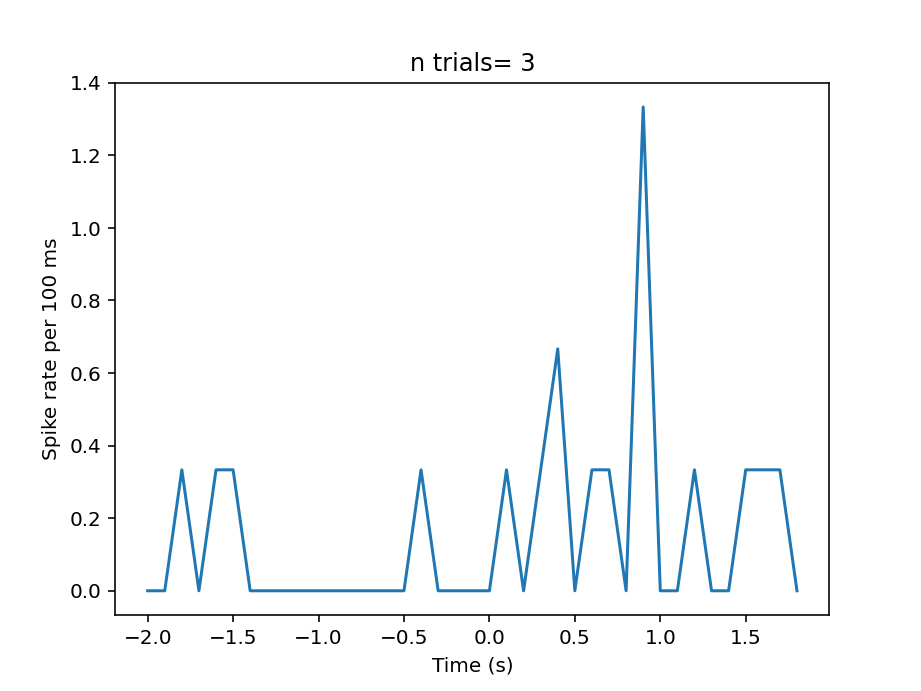

In [96]:
pn.Column(
    pn.Column('## Controls',pn.Row(select_task_w,  target_w, filter_trials_w), pn.pane.Markdown('#### Select units'),unit_ids_w,),
    pn.pane.Matplotlib(PSTH
))

In [94]:
_ = pn.Column(
    pn.Column('## Controls',pn.Row(select_task_w,  target_w, filter_trials_w), pn.pane.Markdown('#### Select units'),unit_ids_w,),
    pn.pane.Matplotlib(PSTH
)).servable()

In [95]:
pn.serve(_)

Launching server at http://localhost:46625
